In [1]:
!pip3 install pandas
!pip3 install seaborn
!pip3 install --upgrade tensorflow-gpu
!pip3 install import-ipynb
!pip3 install cuda-python

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import pickle
import time
import sys

import import_ipynb
import AttackDetectionModel

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils import shuffle

from bayes_opt import BayesianOptimization

%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
importing Jupyter notebook from AttackDetectionModel.ipynb
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 0.333)
sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(gpu_options = gpu_options))

# Data Pre-Processing

In [3]:
number_features = 35

In [4]:
df_benign, df_attack = AttackDetectionModel.get_files_botiot("../../botiot")

df_benign = np.concatenate([df_benign, df_benign, df_benign, df_benign, df_benign, df_benign, df_benign, df_benign, df_benign, df_benign])
df_benign = shuffle(df_benign)

In [5]:
# Normalize with the min-max scaler
scaler = MinMaxScaler()
df_benign_norm = scaler.fit_transform(df_benign)
df_attack_norm = scaler.fit_transform(df_attack)

# Sets

In [6]:
# Train
len_benign_train = int(0.7 * len(df_benign_norm))
X_train = df_benign_norm[:len_benign_train]

In [7]:
# Test
X_test_benign = df_benign_norm[len_benign_train:]
X_test = np.concatenate([X_test_benign, df_attack_norm])

Y_test = np.ones(len(X_test))
Y_test[:len(X_test_benign)] = 0

# Model

In [8]:
# Parameters
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

# Initial values
epochs = 5
learning_rate = 0.0001
batch_size = 10
anomaly_threshold = 0.05

# Dictionary
dict_params = { 'learning_rate': learning_rate, 'batch_size': round(batch_size), 'epochs': round(epochs)}
pbounds = { 'learning_rate': (0.000001, 0.001), 'batch_size': (10, 100), 'epochs': (50, 1500)}

In [9]:
# KL Loss function
def vae_loss(x, x_decoded_mean):
    # Compute the average MSE error, then scale it up (sum on all axes)
    
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    
    # Compute the KL loss
    
    kl_loss = - 0.5 * K.sum(1 + z_var - K.square(z_mean) - K.square(K.exp(z_var)), axis=-1)
    
    # Return the average loss over all 
    
    total_loss = K.mean(reconstruction_loss + kl_loss) # Total_loss = reconstruction_loss + kl_loss 
    return total_loss

# (1) Reconstruction Loss - Forces the encoder to generate latent features that minimize the reconstruction error, or else is
# penalized
# (2) KL Loss - Forces the distribution generated by the encoder to be similar to the prior probability of the input vector, 
# pushing latent feature space to normality

In [10]:
# Encoder
inputs, encoder, z_var, z_mean = AttackDetectionModel.vae_encoder(input_shape, 
                                                                  intermediate_dim, 
                                                                  latent_dim, 
                                                                  AttackDetectionModel.reparametrization)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 35)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 17)           612         ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 11)           198         ['dense[0][0]']                  
                                                                                                  
 z_var (Dense)                  (None, 11)           198         ['dense[0][0]']                  
                                                                                            

In [11]:
# Decoder
decoder = AttackDetectionModel.vae_decoder(intermediate_dim, latent_dim, original_dim)
outputs = decoder(encoder(inputs))
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 11)]              0         
                                                                 
 dense_1 (Dense)             (None, 17)                204       
                                                                 
 dense_2 (Dense)             (None, 35)                630       
                                                                 
Total params: 834
Trainable params: 834
Non-trainable params: 0
_________________________________________________________________


# Hyperparameter Optimization

In [12]:
def maximize_training(X_train = X_train, 
                      X_test = X_test, 
                      Y_test = Y_test, 
                      inputs = inputs, 
                      outputs = outputs, 
                      vae_loss = vae_loss,
                      learning_rate = learning_rate,
                      batch_size = batch_size,
                      epochs = epochs,
                      anomaly_threshold = anomaly_threshold):    
    
    # Create model
    opt_adam = optimizers.Adam(learning_rate = dict_params['learning_rate'], clipvalue = 0.5)
    model = Model(inputs, outputs, name = 'vae_mlp')
    model.compile(optimizer = opt_adam, loss = vae_loss)

    # Train
    history = model.fit(X_train, 
                        X_train, 
                        shuffle = True, 
                        verbose = 0,
                        epochs = dict_params['epochs'], 
                        batch_size = dict_params['batch_size'])
    
    # Maximize the f1-score
    X_pred_opt = model.predict(X_test)
    error_vector_opt = AttackDetectionModel.get_error_term(X_pred_opt, X_test, _rmse = False)
    Y_pred_opt = (error_vector_opt > anomaly_threshold)
    f1 = f1_score(Y_test, Y_pred_opt)
    
    return f1

In [13]:
'''
# Apply Bayesian optimization to choose the best hyperparameters

opt = BayesianOptimization(f = maximize_training,
                           pbounds = pbounds,
                           verbose = 2, 
                           random_state = 1)

opt_start = time.time()

opt.maximize(init_points = 5, n_iter = 5)

opt_end = time.time()
opt_time = opt_end - opt_start
print("Optimization time:", opt_time)

learning_rate = opt.max['params']['learning_rate']
epochs = round(opt.max['params']['epochs'])
batch_size = round(opt.max['params']['batch_size'])
'''

'\n# Apply Bayesian optimization to choose the best hyperparameters\n\nopt = BayesianOptimization(f = maximize_training,\n                           pbounds = pbounds,\n                           verbose = 2, \n                           random_state = 1)\n\nopt_start = time.time()\n\nopt.maximize(init_points = 5, n_iter = 5)\n\nopt_end = time.time()\nopt_time = opt_end - opt_start\nprint("Optimization time:", opt_time)\n\nlearning_rate = opt.max[\'params\'][\'learning_rate\']\nepochs = round(opt.max[\'params\'][\'epochs\'])\nbatch_size = round(opt.max[\'params\'][\'batch_size\'])\n'

# Predict Attacks

In [14]:
# Training step with the best hyperparameters
learning_rate = 0.0005007978127917845
epochs = 1393
batch_size = 19
opt_time = 1151.2620151042938
#anomaly_threshold = 0.001

In [15]:
for i in range(1):
    print("Iteration " + str(i))
    
    # Train
    vae_model, train_time = AttackDetectionModel.train(X_train, inputs, outputs, vae_loss, learning_rate, epochs, batch_size)
    
    # Set the optimized anomaly threshold
    anomaly_threshold = AttackDetectionModel.get_anomaly_threshold(X_train, vae_model)
    
    # Test
    X_pred, test_time = AttackDetectionModel.test(X_test, vae_model)
    Y_test, Y_pred = AttackDetectionModel.get_prediction(Y_test, X_pred, X_test, anomaly_threshold, vae_model)
    
    # Metrics
    acc, f1, pre, rec = AttackDetectionModel.get_scores(Y_test, Y_pred)
    
    # Print results
    AttackDetectionModel.print_results(number_features,
                                       learning_rate,
                                       epochs,
                                       batch_size,
                                       anomaly_threshold,
                                       X_train,
                                       X_test,
                                       opt_time,
                                       train_time,
                                       test_time,
                                       acc,
                                       f1,
                                       pre,
                                       rec,
                                       Y_test,
                                       Y_pred,
                                       "Results/botiot.txt")
    
    print("")

Iteration 0
Train on 3339 samples
Epoch 1/1393
3339/3339 [==============================] - 1s 178us/sample - loss: 107.2773
Epoch 2/1393
3339/3339 [==============================] - 0s 73us/sample - loss: 37.1202
Epoch 3/1393
3339/3339 [==============================] - 0s 67us/sample - loss: 21.1934
Epoch 4/1393
3339/3339 [==============================] - 0s 74us/sample - loss: 17.8563
Epoch 5/1393
3339/3339 [==============================] - 0s 73us/sample - loss: 16.1757
Epoch 6/1393
3339/3339 [==============================] - 0s 71us/sample - loss: 14.9636
Epoch 7/1393
3339/3339 [==============================] - 0s 71us/sample - loss: 13.9041
Epoch 8/1393
3339/3339 [==============================] - 0s 73us/sample - loss: 13.0623
Epoch 9/1393
3339/3339 [==============================] - 0s 71us/sample - loss: 12.6267
Epoch 10/1393
3339/3339 [==============================] - 0s 74us/sample - loss: 12.2903
Epoch 11/1393
3339/3339 [==============================] - 0s 73us/sample

3339/3339 [==============================] - 0s 66us/sample - loss: 7.0554
Epoch 93/1393
3339/3339 [==============================] - 0s 65us/sample - loss: 7.1848
Epoch 94/1393
3339/3339 [==============================] - 0s 63us/sample - loss: 7.0360
Epoch 95/1393
3339/3339 [==============================] - 0s 66us/sample - loss: 7.0047
Epoch 96/1393
3339/3339 [==============================] - 0s 65us/sample - loss: 7.0204
Epoch 97/1393
3339/3339 [==============================] - 0s 66us/sample - loss: 7.0913
Epoch 98/1393
3339/3339 [==============================] - 0s 66us/sample - loss: 6.9959
Epoch 99/1393
3339/3339 [==============================] - 0s 67us/sample - loss: 6.9922
Epoch 100/1393
3339/3339 [==============================] - 0s 67us/sample - loss: 6.9359
Epoch 101/1393
3339/3339 [==============================] - 0s 68us/sample - loss: 6.9287
Epoch 102/1393
3339/3339 [==============================] - 0s 67us/sample - loss: 6.9969
Epoch 103/1393
3339/3339 [======

3339/3339 [==============================] - 0s 64us/sample - loss: 6.3522
Epoch 184/1393
3339/3339 [==============================] - 0s 68us/sample - loss: 6.3954
Epoch 185/1393
3339/3339 [==============================] - 0s 66us/sample - loss: 6.3603
Epoch 186/1393
3339/3339 [==============================] - 0s 64us/sample - loss: 6.4828
Epoch 187/1393
3339/3339 [==============================] - 0s 65us/sample - loss: 6.3401
Epoch 188/1393
3339/3339 [==============================] - 0s 66us/sample - loss: 6.4487
Epoch 189/1393
3339/3339 [==============================] - 0s 64us/sample - loss: 6.3487
Epoch 190/1393
3339/3339 [==============================] - 0s 67us/sample - loss: 6.3723
Epoch 191/1393
3339/3339 [==============================] - 0s 66us/sample - loss: 6.3442
Epoch 192/1393
3339/3339 [==============================] - 0s 67us/sample - loss: 6.3442
Epoch 193/1393
3339/3339 [==============================] - 0s 62us/sample - loss: 6.3290
Epoch 194/1393
3339/3339 

3339/3339 [==============================] - 0s 62us/sample - loss: 6.0627
Epoch 275/1393
3339/3339 [==============================] - 0s 65us/sample - loss: 6.0204
Epoch 276/1393
3339/3339 [==============================] - 0s 65us/sample - loss: 6.0819
Epoch 277/1393
3339/3339 [==============================] - 0s 60us/sample - loss: 6.0403
Epoch 278/1393
3339/3339 [==============================] - 0s 64us/sample - loss: 6.0351
Epoch 279/1393
3339/3339 [==============================] - 0s 65us/sample - loss: 6.0427
Epoch 280/1393
3339/3339 [==============================] - 0s 67us/sample - loss: 6.0579
Epoch 281/1393
3339/3339 [==============================] - 0s 67us/sample - loss: 6.1334
Epoch 282/1393
3339/3339 [==============================] - 0s 68us/sample - loss: 6.0246
Epoch 283/1393
3339/3339 [==============================] - 0s 64us/sample - loss: 6.0478
Epoch 284/1393
3339/3339 [==============================] - 0s 60us/sample - loss: 6.1050
Epoch 285/1393
3339/3339 

3339/3339 [==============================] - 0s 66us/sample - loss: 5.9137
Epoch 366/1393
3339/3339 [==============================] - 0s 64us/sample - loss: 5.9378
Epoch 367/1393
3339/3339 [==============================] - 0s 67us/sample - loss: 5.8949
Epoch 368/1393
3339/3339 [==============================] - 0s 66us/sample - loss: 5.8349
Epoch 369/1393
3339/3339 [==============================] - 0s 66us/sample - loss: 5.8824
Epoch 370/1393
3339/3339 [==============================] - 0s 65us/sample - loss: 5.9167
Epoch 371/1393
3339/3339 [==============================] - 0s 67us/sample - loss: 5.8849
Epoch 372/1393
3339/3339 [==============================] - 0s 65us/sample - loss: 5.8834
Epoch 373/1393
3339/3339 [==============================] - 0s 71us/sample - loss: 5.9531
Epoch 374/1393
3339/3339 [==============================] - 0s 69us/sample - loss: 5.9488
Epoch 375/1393
3339/3339 [==============================] - 0s 66us/sample - loss: 5.8410
Epoch 376/1393
3339/3339 

3339/3339 [==============================] - 0s 65us/sample - loss: 5.7382
Epoch 457/1393
3339/3339 [==============================] - 0s 74us/sample - loss: 5.7001
Epoch 458/1393
3339/3339 [==============================] - 0s 77us/sample - loss: 5.6808
Epoch 459/1393
3339/3339 [==============================] - 0s 70us/sample - loss: 5.8336
Epoch 460/1393
3339/3339 [==============================] - 0s 72us/sample - loss: 5.7644
Epoch 461/1393
3339/3339 [==============================] - 0s 68us/sample - loss: 5.8065
Epoch 462/1393
3339/3339 [==============================] - 0s 69us/sample - loss: 5.7084
Epoch 463/1393
3339/3339 [==============================] - 0s 77us/sample - loss: 5.7549
Epoch 464/1393
3339/3339 [==============================] - 0s 72us/sample - loss: 5.7044
Epoch 465/1393
3339/3339 [==============================] - 0s 76us/sample - loss: 5.7948
Epoch 466/1393
3339/3339 [==============================] - 0s 74us/sample - loss: 5.7419
Epoch 467/1393
3339/3339 

3339/3339 [==============================] - 0s 67us/sample - loss: 5.6892
Epoch 548/1393
3339/3339 [==============================] - 0s 68us/sample - loss: 5.7752
Epoch 549/1393
3339/3339 [==============================] - 0s 68us/sample - loss: 5.7168
Epoch 550/1393
3339/3339 [==============================] - 0s 67us/sample - loss: 5.6819
Epoch 551/1393
3339/3339 [==============================] - 0s 73us/sample - loss: 5.6643
Epoch 552/1393
3339/3339 [==============================] - 0s 70us/sample - loss: 5.6897
Epoch 553/1393
3339/3339 [==============================] - 0s 66us/sample - loss: 5.7017
Epoch 554/1393
3339/3339 [==============================] - 0s 74us/sample - loss: 5.6057
Epoch 555/1393
3339/3339 [==============================] - 0s 66us/sample - loss: 5.7476
Epoch 556/1393
3339/3339 [==============================] - 0s 62us/sample - loss: 5.6538
Epoch 557/1393
3339/3339 [==============================] - 0s 68us/sample - loss: 5.6850
Epoch 558/1393
3339/3339 

3339/3339 [==============================] - 0s 64us/sample - loss: 5.6949
Epoch 639/1393
3339/3339 [==============================] - 0s 57us/sample - loss: 5.6582
Epoch 640/1393
3339/3339 [==============================] - 0s 65us/sample - loss: 5.7060
Epoch 641/1393
3339/3339 [==============================] - 0s 64us/sample - loss: 5.7169
Epoch 642/1393
3339/3339 [==============================] - 0s 58us/sample - loss: 5.7844
Epoch 643/1393
3339/3339 [==============================] - 0s 66us/sample - loss: 5.8037
Epoch 644/1393
3339/3339 [==============================] - 0s 58us/sample - loss: 5.7056
Epoch 645/1393
3339/3339 [==============================] - 0s 58us/sample - loss: 5.7985
Epoch 646/1393
3339/3339 [==============================] - 0s 62us/sample - loss: 5.7128
Epoch 647/1393
3339/3339 [==============================] - 0s 67us/sample - loss: 5.6886
Epoch 648/1393
3339/3339 [==============================] - 0s 56us/sample - loss: 5.7324
Epoch 649/1393
3339/3339 

3339/3339 [==============================] - 0s 62us/sample - loss: 5.7457
Epoch 730/1393
3339/3339 [==============================] - 0s 58us/sample - loss: 5.7933
Epoch 731/1393
3339/3339 [==============================] - 0s 58us/sample - loss: 5.8863
Epoch 732/1393
3339/3339 [==============================] - 0s 66us/sample - loss: 5.8498
Epoch 733/1393
3339/3339 [==============================] - 0s 55us/sample - loss: 5.7476
Epoch 734/1393
3339/3339 [==============================] - 0s 60us/sample - loss: 5.8535
Epoch 735/1393
3339/3339 [==============================] - 0s 60us/sample - loss: 5.9383
Epoch 736/1393
3339/3339 [==============================] - 0s 56us/sample - loss: 5.8035
Epoch 737/1393
3339/3339 [==============================] - 0s 60us/sample - loss: 5.8009
Epoch 738/1393
3339/3339 [==============================] - 0s 60us/sample - loss: 5.8079
Epoch 739/1393
3339/3339 [==============================] - 0s 55us/sample - loss: 5.8851
Epoch 740/1393
3339/3339 

3339/3339 [==============================] - 0s 61us/sample - loss: 5.8315
Epoch 821/1393
3339/3339 [==============================] - 0s 58us/sample - loss: 6.0098
Epoch 822/1393
3339/3339 [==============================] - 0s 60us/sample - loss: 5.8547
Epoch 823/1393
3339/3339 [==============================] - 0s 62us/sample - loss: 5.9121
Epoch 824/1393
3339/3339 [==============================] - 0s 59us/sample - loss: 5.9899
Epoch 825/1393
3339/3339 [==============================] - 0s 64us/sample - loss: 5.9850
Epoch 826/1393
3339/3339 [==============================] - 0s 64us/sample - loss: 5.8446
Epoch 827/1393
3339/3339 [==============================] - 0s 56us/sample - loss: 5.8255
Epoch 828/1393
3339/3339 [==============================] - 0s 62us/sample - loss: 5.9416
Epoch 829/1393
3339/3339 [==============================] - 0s 60us/sample - loss: 6.0524
Epoch 830/1393
3339/3339 [==============================] - 0s 60us/sample - loss: 5.9972
Epoch 831/1393
3339/3339 

3339/3339 [==============================] - 0s 61us/sample - loss: 5.9997
Epoch 912/1393
3339/3339 [==============================] - 0s 71us/sample - loss: 5.9068
Epoch 913/1393
3339/3339 [==============================] - 0s 67us/sample - loss: 6.0664
Epoch 914/1393
3339/3339 [==============================] - 0s 60us/sample - loss: 5.9898
Epoch 915/1393
3339/3339 [==============================] - 0s 68us/sample - loss: 6.0132
Epoch 916/1393
3339/3339 [==============================] - 0s 65us/sample - loss: 6.0371
Epoch 917/1393
3339/3339 [==============================] - 0s 61us/sample - loss: 5.9926
Epoch 918/1393
3339/3339 [==============================] - 0s 69us/sample - loss: 6.0462
Epoch 919/1393
3339/3339 [==============================] - 0s 60us/sample - loss: 6.0574
Epoch 920/1393
3339/3339 [==============================] - 0s 63us/sample - loss: 6.0710
Epoch 921/1393
3339/3339 [==============================] - 0s 72us/sample - loss: 6.0185
Epoch 922/1393
3339/3339 

3339/3339 [==============================] - 0s 59us/sample - loss: 5.9435
Epoch 1003/1393
3339/3339 [==============================] - 0s 70us/sample - loss: 6.0014
Epoch 1004/1393
3339/3339 [==============================] - 0s 62us/sample - loss: 5.9953
Epoch 1005/1393
3339/3339 [==============================] - 0s 62us/sample - loss: 6.0687
Epoch 1006/1393
3339/3339 [==============================] - 0s 67us/sample - loss: 5.9973
Epoch 1007/1393
3339/3339 [==============================] - 0s 62us/sample - loss: 6.0450
Epoch 1008/1393
3339/3339 [==============================] - 0s 69us/sample - loss: 6.0970
Epoch 1009/1393
3339/3339 [==============================] - 0s 62us/sample - loss: 6.2134
Epoch 1010/1393
3339/3339 [==============================] - 0s 61us/sample - loss: 6.0570
Epoch 1011/1393
3339/3339 [==============================] - 0s 72us/sample - loss: 6.0447
Epoch 1012/1393
3339/3339 [==============================] - 0s 65us/sample - loss: 6.1607
Epoch 1013/1393

3339/3339 [==============================] - 0s 54us/sample - loss: 6.0380
Epoch 1093/1393
3339/3339 [==============================] - 0s 52us/sample - loss: 6.2393
Epoch 1094/1393
3339/3339 [==============================] - 0s 54us/sample - loss: 6.0776
Epoch 1095/1393
3339/3339 [==============================] - 0s 54us/sample - loss: 6.0046
Epoch 1096/1393
3339/3339 [==============================] - 0s 53us/sample - loss: 6.0406
Epoch 1097/1393
3339/3339 [==============================] - 0s 54us/sample - loss: 6.0440
Epoch 1098/1393
3339/3339 [==============================] - 0s 53us/sample - loss: 6.0894
Epoch 1099/1393
3339/3339 [==============================] - 0s 54us/sample - loss: 5.9517
Epoch 1100/1393
3339/3339 [==============================] - 0s 54us/sample - loss: 6.0141
Epoch 1101/1393
3339/3339 [==============================] - 0s 55us/sample - loss: 6.0326
Epoch 1102/1393
3339/3339 [==============================] - 0s 55us/sample - loss: 6.0376
Epoch 1103/1393

3339/3339 [==============================] - 0s 77us/sample - loss: 5.9709
Epoch 1183/1393
3339/3339 [==============================] - 0s 82us/sample - loss: 6.0161
Epoch 1184/1393
3339/3339 [==============================] - 0s 86us/sample - loss: 6.0606
Epoch 1185/1393
3339/3339 [==============================] - 0s 84us/sample - loss: 6.0652
Epoch 1186/1393
3339/3339 [==============================] - 0s 95us/sample - loss: 6.1871
Epoch 1187/1393
3339/3339 [==============================] - 0s 77us/sample - loss: 6.0806
Epoch 1188/1393
3339/3339 [==============================] - 0s 98us/sample - loss: 6.0264
Epoch 1189/1393
3339/3339 [==============================] - 0s 87us/sample - loss: 6.1555
Epoch 1190/1393
3339/3339 [==============================] - 0s 100us/sample - loss: 5.9868
Epoch 1191/1393
3339/3339 [==============================] - 0s 100us/sample - loss: 5.9776
Epoch 1192/1393
3339/3339 [==============================] - 0s 95us/sample - loss: 5.9734
Epoch 1193/13

3339/3339 [==============================] - 0s 102us/sample - loss: 6.0473
Epoch 1272/1393
3339/3339 [==============================] - 0s 102us/sample - loss: 6.1206
Epoch 1273/1393
3339/3339 [==============================] - 0s 107us/sample - loss: 6.1296
Epoch 1274/1393
3339/3339 [==============================] - 0s 108us/sample - loss: 5.9374
Epoch 1275/1393
3339/3339 [==============================] - 0s 105us/sample - loss: 5.9768
Epoch 1276/1393
3339/3339 [==============================] - 0s 102us/sample - loss: 6.0816
Epoch 1277/1393
3339/3339 [==============================] - 0s 107us/sample - loss: 6.0124
Epoch 1278/1393
3339/3339 [==============================] - 0s 105us/sample - loss: 5.9877
Epoch 1279/1393
3339/3339 [==============================] - 0s 105us/sample - loss: 5.9824
Epoch 1280/1393
3339/3339 [==============================] - 0s 102us/sample - loss: 6.0093
Epoch 1281/1393
3339/3339 [==============================] - 0s 100us/sample - loss: 6.0640
Epoc

3339/3339 [==============================] - 0s 63us/sample - loss: 6.0137
Epoch 1361/1393
3339/3339 [==============================] - 0s 63us/sample - loss: 6.0681
Epoch 1362/1393
3339/3339 [==============================] - 0s 61us/sample - loss: 6.1394
Epoch 1363/1393
3339/3339 [==============================] - 0s 61us/sample - loss: 6.1199
Epoch 1364/1393
3339/3339 [==============================] - 0s 59us/sample - loss: 6.1384
Epoch 1365/1393
3339/3339 [==============================] - 0s 58us/sample - loss: 6.1031
Epoch 1366/1393
3339/3339 [==============================] - 0s 56us/sample - loss: 6.0554
Epoch 1367/1393
3339/3339 [==============================] - 0s 56us/sample - loss: 6.1526
Epoch 1368/1393
3339/3339 [==============================] - 0s 56us/sample - loss: 6.0468
Epoch 1369/1393
3339/3339 [==============================] - 0s 57us/sample - loss: 6.0564
Epoch 1370/1393
3339/3339 [==============================] - 0s 82us/sample - loss: 6.0116
Epoch 1371/1393

/home/andressa.amaral/.local/lib/python3.7/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Testing time: 92.55370140075684



# Metrics

In [16]:
# Examinig the latent space generated by the encoder
X_encoded = encoder.predict(X_test)

pca = PCA(n_components=2)
X_analysis = pca.fit_transform(X_encoded)

/home/andressa.amaral/.local/lib/python3.7/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


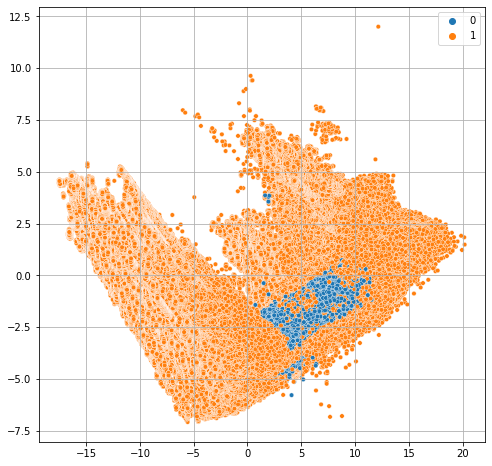

In [17]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_pred)
plt.grid()
plt.savefig("Results/PCA/Botiot")
plt.show()

# Orange ones are anomalies

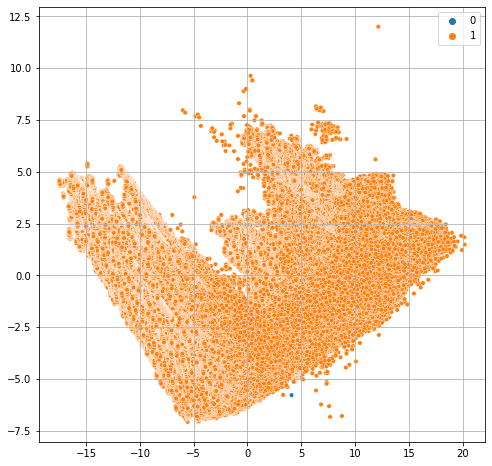

In [18]:
plt.figure(figsize = (8, 8))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test)
plt.grid()
plt.savefig("Results/PCA Groundtruth/Botiot")
plt.show()

# Ground truth

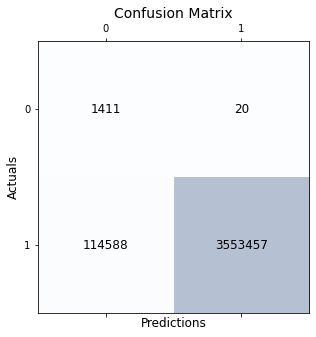

In [19]:
conf_matrix = confusion_matrix(Y_test, Y_pred)

fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(conf_matrix, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x = j, y = i,s = conf_matrix[i, j], va = 'center', ha = 'center', size = 'large')
 
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.savefig("Results/Confusion Matrix/Botiot")
plt.show()